# <center>Data Exploration (NSL-KDD)</center>

In [57]:
import sys
sys.path.append('../utils')
sys.path.append('../models')

import numpy as np
import pandas as pd

import preprocessing
from cgan import CGAN
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

# import pandas_profiling
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [58]:
train,test, label_mapping = preprocessing.get_data(encoding="Label")
data_cols = list(train.columns[ train.columns != 'label' ])
train = preprocessing.normalize_data(train,data_cols)
test = preprocessing.normalize_data(test,data_cols)
x_train , x_test = preprocessing.preprocess(train,test,data_cols,"Robust",True)
# x_train = preprocessing.remove_outliers(train)

# train, test = None, None
y_train = x_train.label.values
y_test = x_test.label.values

d:\WorkSpace\GAN\GANs_for_Network_Intrusion_Data\NSL-KDD\notebooks
True


In [59]:
data_cols = list(x_train.columns[ x_train.columns != 'label' ])

to_drop = preprocessing.get_contant_featues(x_train,data_cols,threshold=0.995)
x_train.drop(to_drop, axis=1,inplace=True)
x_test.drop(to_drop, axis=1,inplace=True)

data_cols = list(x_train.columns[ x_train.columns != 'label' ])
print("Total data features : {}".format(len(data_cols)))

Total data features : 25


In [60]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,-0.005426,-0.010681,-0.004034,0.902520,0.000000,0.0,0.0,0.000000,0.0,...,-0.149771,-0.013509,0.000946,0.000708,0.006127,0.000000,0.000000,0.001842,0.00000,1
1,0.0,0.027664,-0.004616,0.002431,0.443658,0.000000,0.0,0.0,0.000000,0.0,...,0.425462,-0.058759,-0.004093,0.048518,0.055422,0.000000,0.000000,0.000000,0.00000,1
2,0.0,0.005282,0.000069,0.018581,-0.052693,0.000000,0.0,0.0,0.000000,0.0,...,0.455175,0.029288,0.001265,0.003542,0.000000,0.000000,0.156287,0.000000,0.00000,0
3,0.0,-0.017853,-0.012499,-0.012138,-0.024263,0.999103,0.0,0.0,0.008236,0.0,...,-0.437979,-0.030902,-0.002226,-0.000700,0.000068,0.000119,0.000163,0.000000,0.00002,1
4,0.0,-0.007132,-0.004639,-0.005147,0.284645,0.711973,0.0,0.0,0.113934,0.0,...,-0.009287,0.370241,0.021736,-0.000700,0.000000,0.000000,0.000000,0.000000,0.00000,1


### Try to remove outliers without losing much data

In [61]:
Q1 = x_train.drop('label',axis=1).quantile(0.1)
Q3 = x_train.drop('label',axis=1).quantile(0.99)
IQR = Q3 - Q1
print(IQR)

duration                       0.998940
protocol_type                  0.377512
service                        0.307238
flag                           0.191159
src_bytes                      0.999877
dst_bytes                      0.999887
wrong_fragment                 0.000000
hot                            0.346308
logged_in                      0.241673
num_compromised                0.018445
is_guest_login                 0.000000
count                          0.908346
srv_count                      0.592728
same_srv_rate                  0.309939
diff_srv_rate                  0.449351
srv_diff_host_rate             0.315123
dst_host_count                 0.991532
dst_host_srv_count             0.993406
dst_host_same_srv_rate         0.309082
dst_host_diff_srv_rate         0.093651
dst_host_same_src_port_rate    0.335802
dst_host_srv_diff_host_rate    0.234191
dst_host_serror_rate           0.215609
dst_host_rerror_rate           0.122133
dst_host_srv_rerror_rate       0.114470


In [62]:
#Remove samples containing extreme values
mask = ~((x_train.drop('label',axis=1) < (Q1 - 1.5 * IQR)) | \
         (x_train.drop('label',axis=1) > (Q3 + 1.5 * IQR))).any(axis=1)

In [63]:
x_train[mask].max(axis=0)

duration                       1.000018
protocol_type                  0.892165
service                        0.750068
flag                           0.460933
src_bytes                      0.947307
dst_bytes                      1.000003
wrong_fragment                 0.000000
hot                            0.865725
logged_in                      0.600640
num_compromised                0.045639
is_guest_login                 0.000000
count                          1.001735
srv_count                      1.063105
same_srv_rate                  0.568727
diff_srv_rate                  1.110676
srv_diff_host_rate             0.786681
dst_host_count                 0.558467
dst_host_srv_count             0.937917
dst_host_same_srv_rate         0.674489
dst_host_diff_srv_rate         0.232401
dst_host_same_src_port_rate    0.825049
dst_host_srv_diff_host_rate    0.575683
dst_host_serror_rate           0.534993
dst_host_rerror_rate           0.304757
dst_host_srv_rerror_rate       0.284777


# Load data

In [64]:
# Read keras model
from keras.models import load_model

model_name = '32_1000_128_1_1_00005_4_relu_adam_27_3'
combined_model_path = f'./models/{model_name}_combined_model.h5'
g_model_path = f'./models/{model_name}_generator_model.h5'
model = load_model(combined_model_path)


### <center>TSNE </center>
Didn't work!!

In [65]:
# import pickle
# pickle_file_path = './logs/32_200_128_1_1_00005_8_relu_sgd_17.pickle'

# with open(pickle_file_path, 'rb') as file:
#     H = pickle.load(file)  # 反序列化并加载字典

# # 输出字典内容
# print(H)

# rand_noise_dim = H["rand_noise_dim"]
# tot_epochs = H["total_epochs"]
# n_layers = H["n_layers"]
# activation = H["activation"]
# learning_rate = H["learning_rate"]
# batch_size = H["batch_size"]
# min_num_neurones = H["min_num_neurones"]
# optimizer = H["optimizer"]

# [[32], tot_epochs, batch_size, [1], [1],
#                              learning_rate, n_layers, activation, optimizer, base_n_count]
 

# # 将模型参数重构成列表，便于初始化CGAN
# arguments = [rand_noise_dim,tot_epochs, batch_size, 1, 1, learning_rate, n_layers, activation, optimizer, min_num_neurones]

# # 示例数据
# X_train = np.random.rand(1000, 20)  # 1000个样本，每个样本有20个特征
# y_train = np.random.randint(0, 2, size=(1000, 1))  # 二分类标签

# cgan_model = CGAN(arguments, X_train, y_train)


In [66]:
# val, counts = np.unique(y_train,return_counts=True)
# gen_labels = np.array([i.tolist() for j in zip(val,counts) for i in np.repeat(j[0],j[1])])[:,np.newaxis]
# gen_train = model.generate_data(gen_labels)

In [67]:
# Real_embedded = TSNE(n_components=2,n_iter=500,verbose=1).fit_transform(x)
# Fake_embedded =  TSNE(n_components=2,n_iter=500,verbose=1).fit_transform(gen_train)

In [68]:
# plt.figure(figsize=(16,10))
# palette = sns.color_palette("bright", 4)
# sns.scatterplot(Real_embedded[:,0], Real_embedded[:,1], hue=y, legend='full', palette=palette)
# sns.scatterplot(Fake_embedded[:,0], Fake_embedded[:,1], hue=gen_labels, legend='full', palette=palette)
# plt.show()

In [69]:
# mask = np.where(y == 3)
# plt.figure(figsize=(16,10))
# palette = sns.color_palette("bright", 4)
# plt.scatter(Real_embedded[mask,0], Real_embedded[mask,1])
# plt.scatter(Fake_embedded[mask,0], Fake_embedded[mask,1])
# plt.show()

## <center>Explore each attack separately before & after sysnthetic data generation</center>
Mainly visualise the difference between real attacks and syntheticly generated data using Principal component analysis

## Read Data and GAN
- Normalizing 
- Scaling 
- Removing highly correlated features
- Remove Constant values features



In [70]:
train,test, label_mapping = preprocessing.get_data(encoding="Label")
data_cols = list(train.columns[ train.columns != 'label' ])
train = preprocessing.normalize_data(train,data_cols)
test = preprocessing.normalize_data(test,data_cols)
x_train , x_test = preprocessing.preprocess(train,test,data_cols,"Robust",True)
# x_train = preprocessing.remove_outliers(train)

# train, test = None, None
y_train = x_train.label.values
y_test = x_test.label.values

d:\WorkSpace\GAN\GANs_for_Network_Intrusion_Data\NSL-KDD\notebooks
True


In [71]:
data_cols = list(x_train.columns[ x_train.columns != 'label' ])
to_drop = preprocessing.get_contant_featues(x_train,data_cols,threshold=0.995)
x_train.drop(to_drop, axis=1,inplace=True)
x_test.drop(to_drop, axis=1,inplace=True)
data_cols = list(x_train.columns[ x_train.columns != 'label' ])

print("Total data features : {}".format(len(data_cols)))

Total data features : 25


### <center>Normal</center>

In [72]:
normal_df = x_train.query('label == 1')
print("# of samples : {}".format(normal_df.shape[0]))

# of samples : 67343


In [73]:
normal_df[data_cols]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,hot,logged_in,num_compromised,...,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.00000,-0.005426,-0.010681,-0.004034,0.902520,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,-0.149771,-0.013509,0.000946,0.000708,0.006127,0.000000,0.000000,0.001842,0.00000
1,0.00000,0.027664,-0.004616,0.002431,0.443658,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.425462,-0.058759,-0.004093,0.048518,0.055422,0.000000,0.000000,0.000000,0.00000
3,0.00000,-0.017853,-0.012499,-0.012138,-0.024263,0.999103,0.0,0.0,0.008236,0.0,...,0.000000,-0.437979,-0.030902,-0.002226,-0.000700,0.000068,0.000119,0.000163,0.000000,0.00002
4,0.00000,-0.007132,-0.004639,-0.005147,0.284645,0.711973,0.0,0.0,0.113934,0.0,...,0.003086,-0.009287,0.370241,0.021736,-0.000700,0.000000,0.000000,0.000000,0.000000,0.00000
12,0.00000,-0.015699,-0.010919,-0.010733,0.073195,0.987371,0.0,0.0,0.029481,0.0,...,0.003816,-0.438146,0.033931,0.002591,-0.000700,0.000975,0.000319,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125965,0.00000,-0.015676,-0.004276,-0.010718,0.934183,0.161313,0.0,0.0,0.029704,0.0,...,0.000000,-0.441214,-0.061276,0.002641,-0.000700,0.008187,0.010716,0.000000,0.000000,0.00000
125967,0.00000,-0.006905,-0.004472,-0.004999,0.567850,0.648202,0.0,0.0,0.116176,0.0,...,0.006294,-0.436469,0.378751,0.022244,-0.000700,0.010567,0.001676,0.025354,0.000000,0.00000
125969,0.02021,0.015755,-0.003642,-0.001452,0.212557,0.366299,0.0,0.0,0.000000,0.0,...,0.000000,0.202675,0.554421,0.032858,-0.000091,0.000468,0.000000,0.000000,0.000000,0.00000
125970,0.00000,-0.015697,-0.004337,-0.010732,0.926512,0.168541,0.0,0.0,0.029499,0.0,...,0.000000,-0.329708,-0.048989,-0.003290,-0.000065,0.000000,0.000000,0.014046,0.000083,0.00000


In [74]:
Q1 = normal_df[data_cols].quantile(0.25)
Q3 = normal_df[data_cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

duration                       0.000000
protocol_type                  0.021780
service                        0.017739
flag                           0.008257
src_bytes                      0.409137
dst_bytes                      0.822143
wrong_fragment                 0.000000
hot                            0.000000
logged_in                      0.063440
num_compromised                0.000000
is_guest_login                 0.000000
count                          0.013380
srv_count                      0.017897
same_srv_rate                  0.022457
diff_srv_rate                  0.000000
srv_diff_host_rate             0.001010
dst_host_count                 0.365920
dst_host_srv_count             0.401376
dst_host_same_srv_rate         0.024947
dst_host_diff_srv_rate         0.000583
dst_host_same_src_port_rate    0.001108
dst_host_srv_diff_host_rate    0.000408
dst_host_serror_rate           0.000000
dst_host_rerror_rate           0.000000
dst_host_srv_rerror_rate       0.000000


In [75]:
# swarm_plot = sns.pairplot(train.query('label != 1'),hue='label')
# # fig = swarm_plot.get_figure()
# plt.savefig("all.png",dpi = 300)

### <center>DoS</center>

In [76]:
# Read keras model
from keras.models import load_model
# model_path = './models/32_2000_128_1_1_00005_4_tanh_sgd_17_generator_model.h5'

model = load_model(g_model_path)

In [77]:
dos_df = x_train.query('label == 0')
print("Number of samples : {}".format(dos_df.shape[0]))

Number of samples : 45927


In [78]:
Q1 = dos_df[data_cols].quantile(0.25)
Q3 = dos_df[data_cols].quantile(0.75)
IQR = Q3 - Q1
# print(IQR)

(45927, 32)
1436/1436 [==============================] - 2s 1ms/step
(45927, 25)


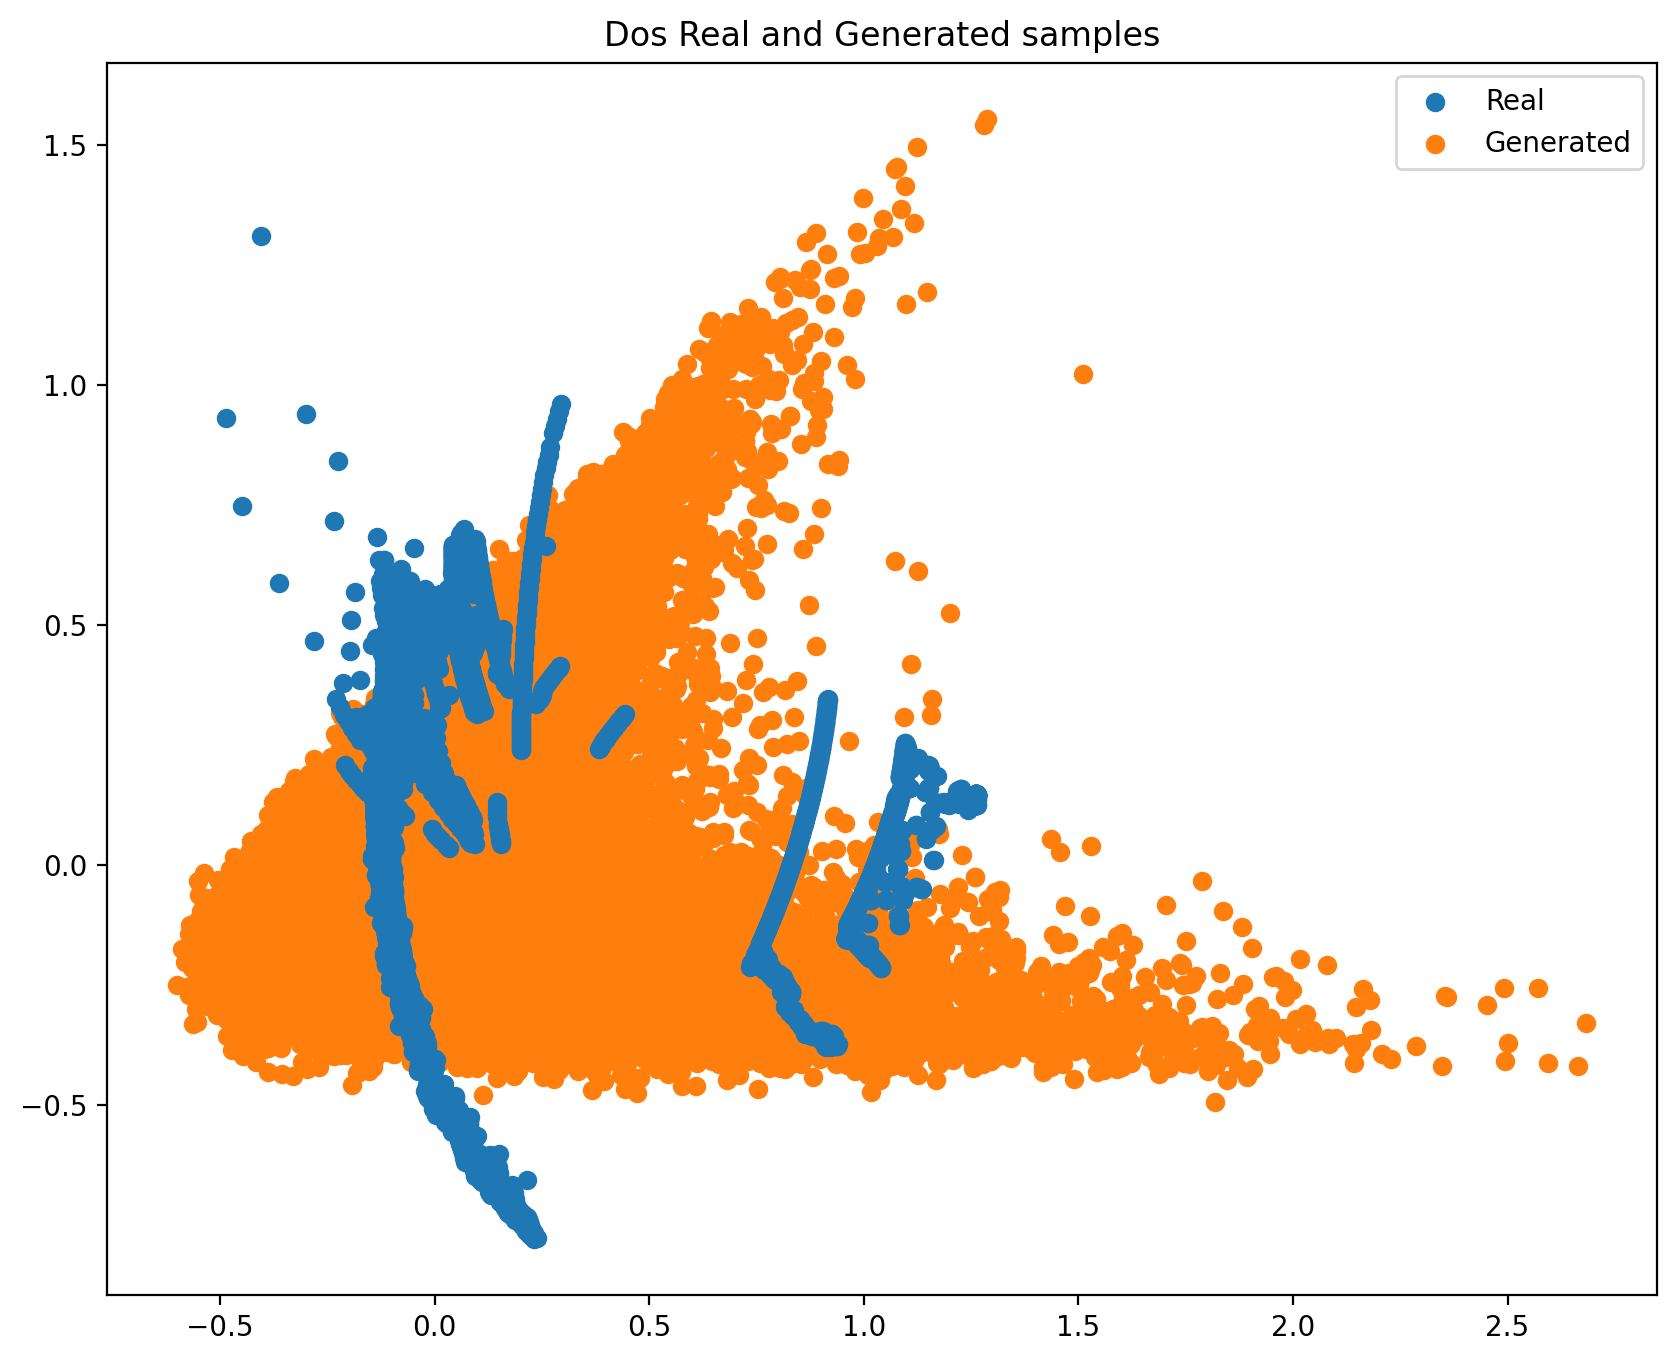

In [79]:
#Plot the difference of fake and real attacks

figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')

pca = PCA(n_components=2)
pca.fit(dos_df.drop("label",axis=1))
decomposed_probe_df = pca.transform(dos_df.drop("label",axis=1))

noise = np.random.normal(0, 1, (len(dos_df), 32))
print(noise.shape)

generated_probe = model.predict([noise, dos_df.label.values.reshape(-1,1)])[:,:-1]
print(generated_probe.shape)
gen_decomposed = PCA(n_components=2).fit_transform(generated_probe)
plt.scatter(x=decomposed_probe_df[:,0],y=decomposed_probe_df[:,1],label="Real",zorder=2)
plt.scatter(x=gen_decomposed[:,0],y=gen_decomposed[:,1],label="Generated",zorder=1)
plt.title("Dos Real and Generated samples")
plt.legend()
plt.show()

### <center>Probe</center>

In [80]:
probe_df = x_train.query('label == 2')
print("Number of probe attack samples : {}".format(probe_df.shape[0]))

Number of probe attack samples : 11656


In [81]:
Q1 = probe_df[data_cols].quantile(0.25)
Q3 = probe_df[data_cols].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

duration                       0.000000
protocol_type                  0.148229
service                        0.095629
flag                           0.051539
src_bytes                      0.078679
dst_bytes                      0.000000
wrong_fragment                 0.000000
hot                            0.000000
logged_in                      0.000000
num_compromised                0.000000
is_guest_login                 0.000000
count                          0.121749
srv_count                      0.147113
same_srv_rate                  0.130461
diff_srv_rate                  0.190043
srv_diff_host_rate             0.119201
dst_host_count                 0.963199
dst_host_srv_count             0.875661
dst_host_same_srv_rate         0.115628
dst_host_diff_srv_rate         0.048098
dst_host_same_src_port_rate    0.144846
dst_host_srv_diff_host_rate    0.089568
dst_host_serror_rate           0.001882
dst_host_rerror_rate           0.035245
dst_host_srv_rerror_rate       0.036692


(11656, 32)
365/365 [==============================] - 0s 1ms/step
(11656, 25)


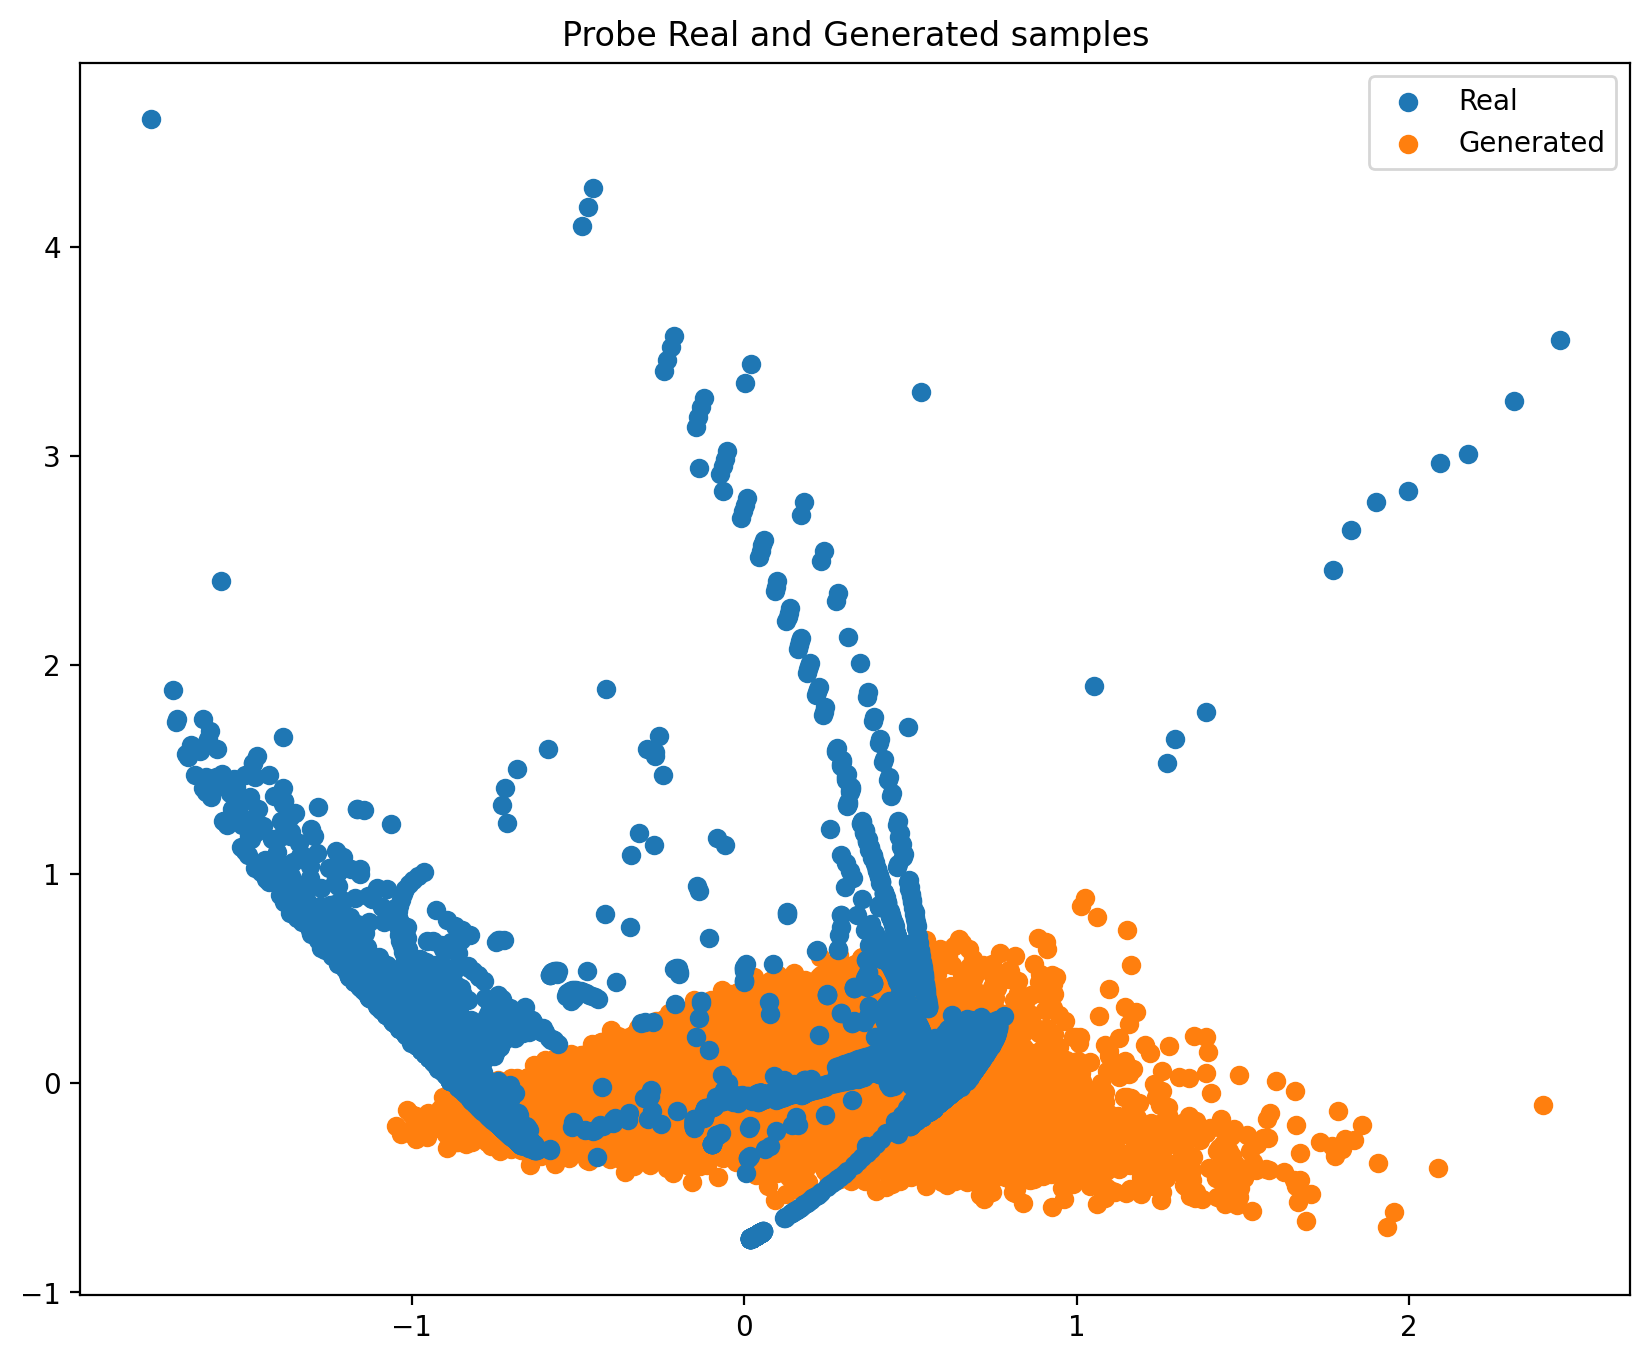

In [82]:
#Plot the difference of fake and real attacks

figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')

pca = PCA(n_components=2)
pca.fit(probe_df.drop("label",axis=1))
decomposed_probe_df = pca.transform(probe_df.drop("label",axis=1))

noise = np.random.normal(0, 1, (len(probe_df), 32))
print(noise.shape)

generated_probe = model.predict([noise, probe_df.label.values.reshape(-1,1)])[:,:-1]
print(generated_probe.shape)
gen_decomposed = PCA(n_components=2).fit_transform(generated_probe)
plt.scatter(x=decomposed_probe_df[:,0],y=decomposed_probe_df[:,1],label="Real", zorder=2)
plt.scatter(x=gen_decomposed[:,0],y=gen_decomposed[:,1],label="Generated", zorder=1)
plt.title("Probe Real and Generated samples")
plt.legend()
plt.show()

### <center>R2L</center>

In [83]:
r2l_df = x_train.query('label == 3')
print("Number of R2L samples : {}".format(r2l_df.shape[0]))

Number of R2L samples : 995


In [84]:
Q1 = r2l_df[data_cols].quantile(0.25)
Q3 = r2l_df[data_cols].quantile(0.75)
IQR = Q3 - Q1
# print(IQR)

32/32 [==============================] - 0s 1ms/step


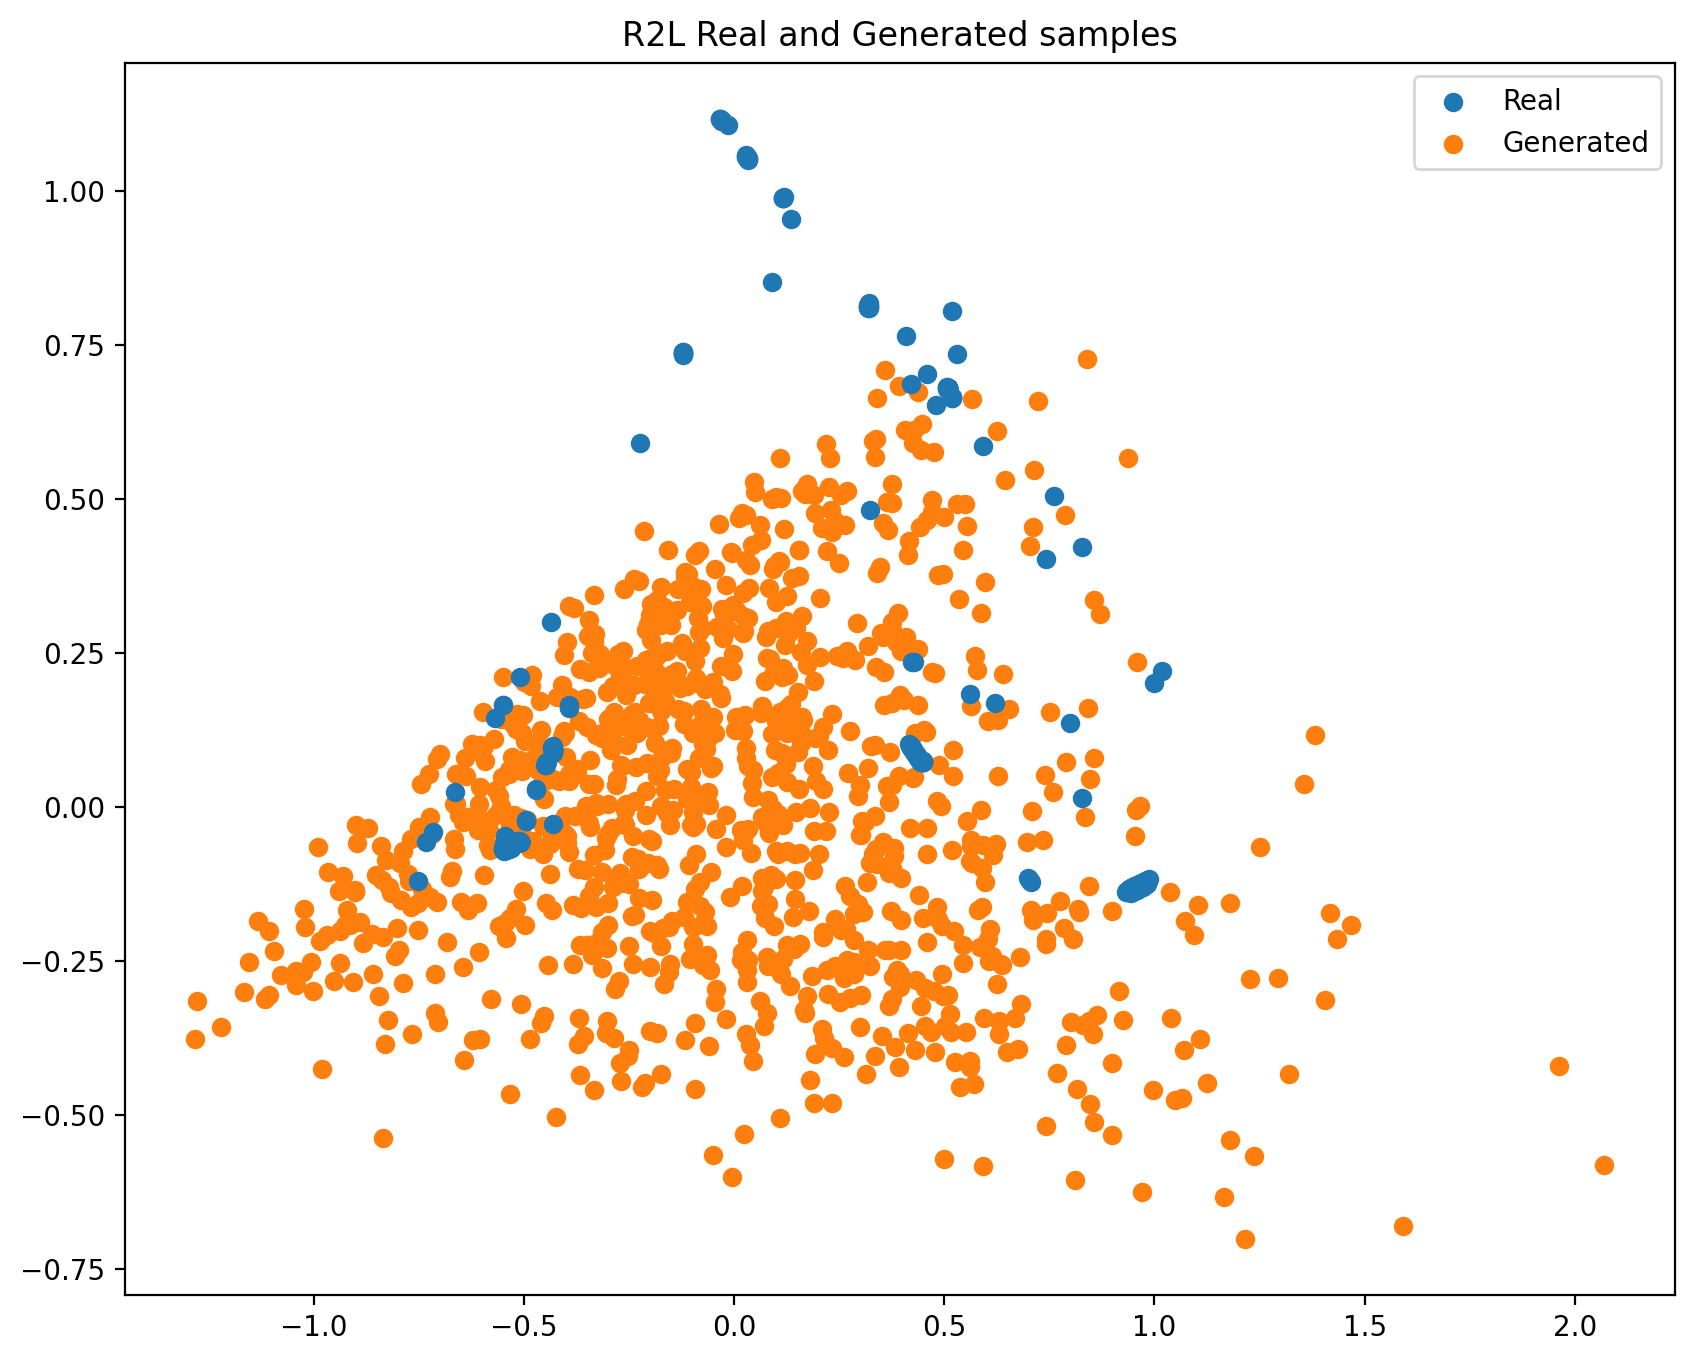

In [85]:
#Plot the difference of fake and real attacks
figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')

pca = PCA(n_components=2)
pca.fit(r2l_df.drop("label",axis=1))
decomposed_r2l_df = pca.transform(r2l_df.drop("label",axis=1))

noise = np.random.normal(0, 1, (len(r2l_df), 32))
generated_r2l = model.predict([noise, r2l_df.label.values.reshape(-1,1)])[:,:-1]

gen_decomposed = PCA(n_components=2).fit_transform(generated_r2l)
plt.scatter(x=decomposed_r2l_df[:,0],y=decomposed_r2l_df[:,1],label="Real", zorder=2)
plt.scatter(x=gen_decomposed[:,0],y=gen_decomposed[:,1],label="Generated", zorder=1)
plt.title("R2L Real and Generated samples")
plt.legend()
plt.show()

### <center>U2R</center>

In [86]:
u2r_df = x_train.query('label == 4')
print("# of samples : {}".format(u2r_df.shape[0]))

# of samples : 52


In [87]:
# swarm_plot = sns.pairplot(u2r_df)
# # fig = swarm_plot.get_figure()
# plt.savefig("ur3.png",dpi = 300)

Q1 = u2r_df[data_cols].quantile(0.25)
Q3 = u2r_df[data_cols].quantile(0.75)
IQR = Q3 - Q1
# print(IQR)

mask = ~((train[data_cols] < (Q1 - 1.5 * IQR)) |(train[data_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

2/2 [==============================] - 0s 3ms/step


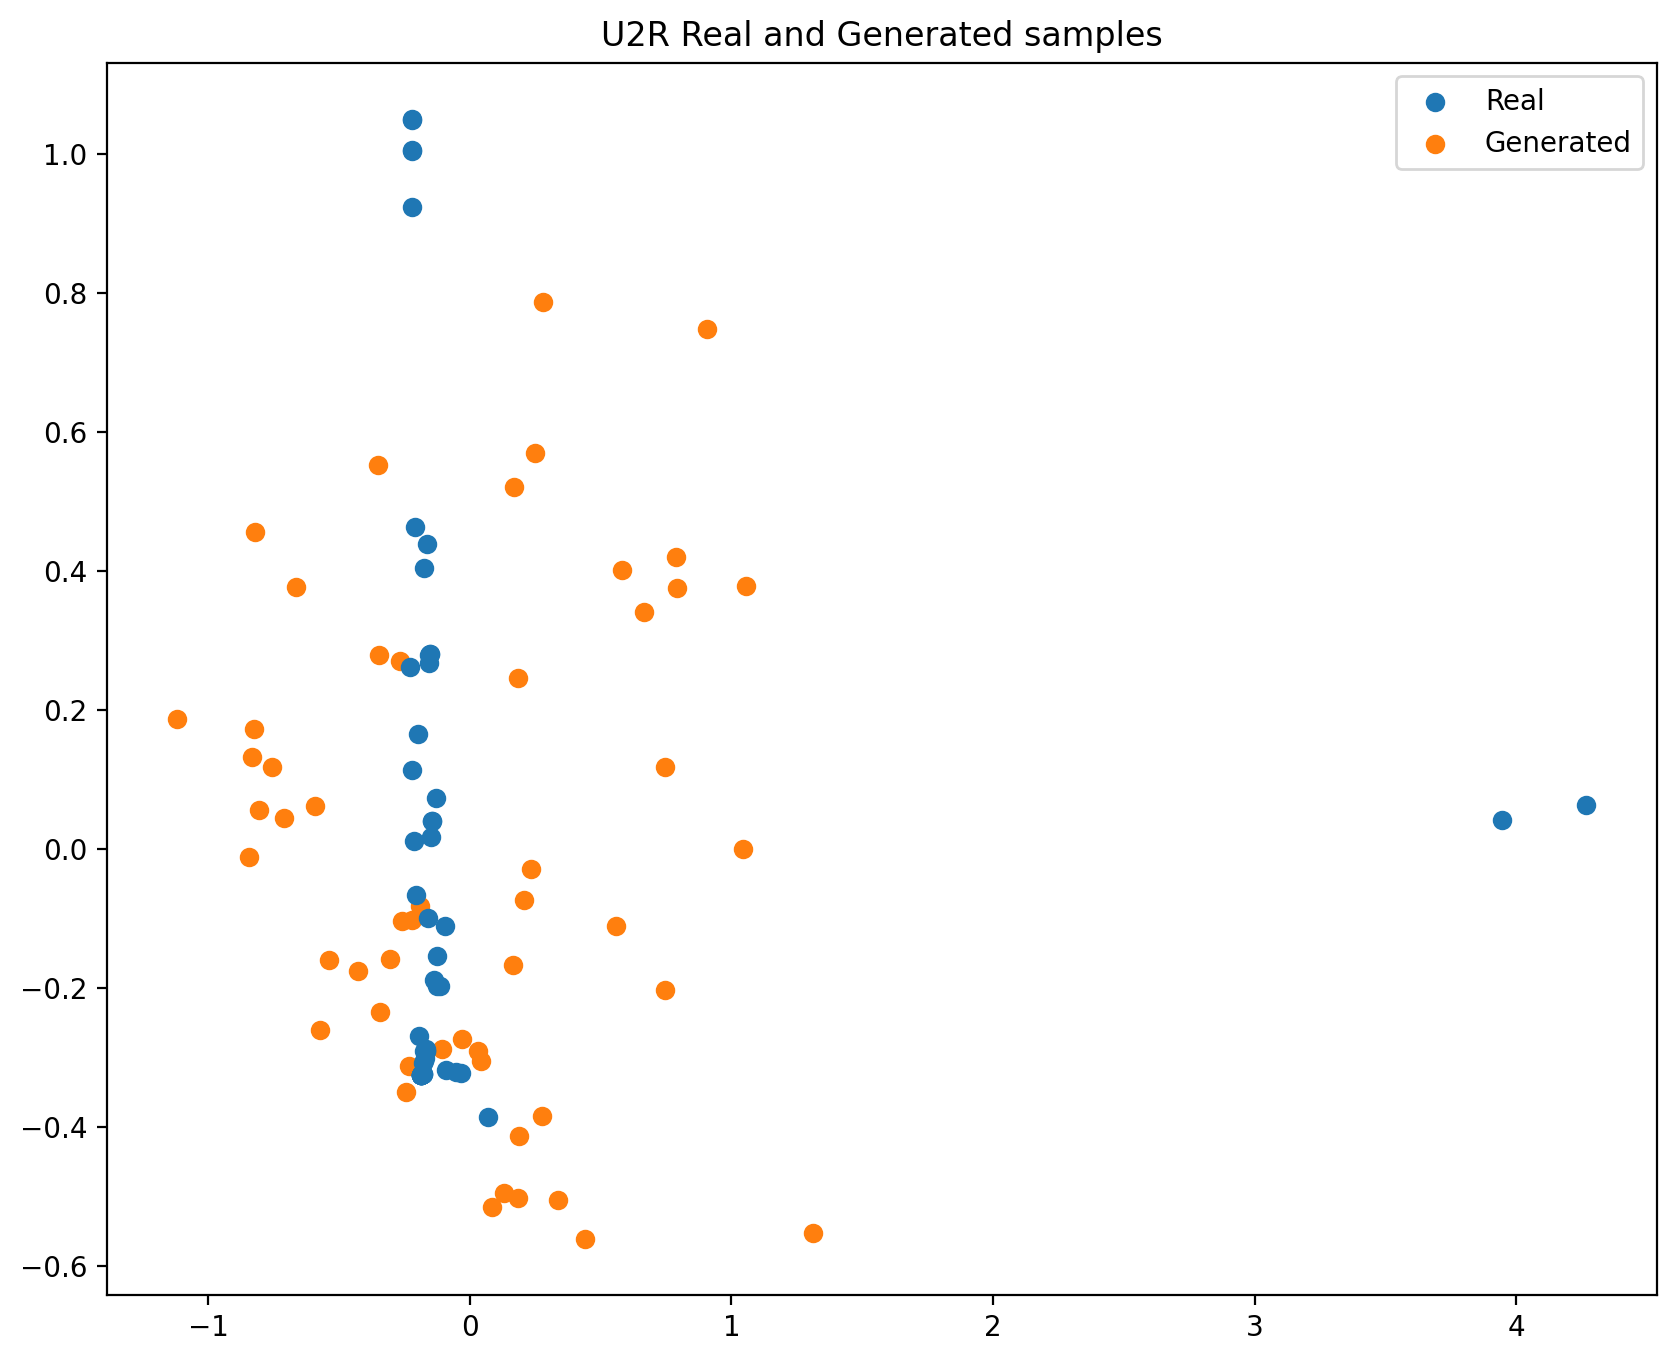

In [88]:
#Plot the difference of fake and real attacks
figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')

pca = PCA(n_components=2)
pca.fit(u2r_df.drop("label",axis=1))
decomposed_u2r_df = pca.transform(u2r_df.drop("label",axis=1))

noise = np.random.normal(0, 1, (len(u2r_df), 32))
generated_u2r = model.predict([noise, u2r_df.label.values.reshape(-1,1)])[:,:-1]

gen_decomposed = PCA(n_components=2).fit_transform(generated_u2r)
plt.scatter(x=decomposed_u2r_df[:,0],y=decomposed_u2r_df[:,1],label='Real', zorder=2)
plt.scatter(x=gen_decomposed[:,0],y=gen_decomposed[:,1],label='Generated', zorder=1)
plt.title("U2R Real and Generated samples")
plt.legend()
plt.show()

### TSNE

1436/1436 [==============================] - 2s 1ms/step


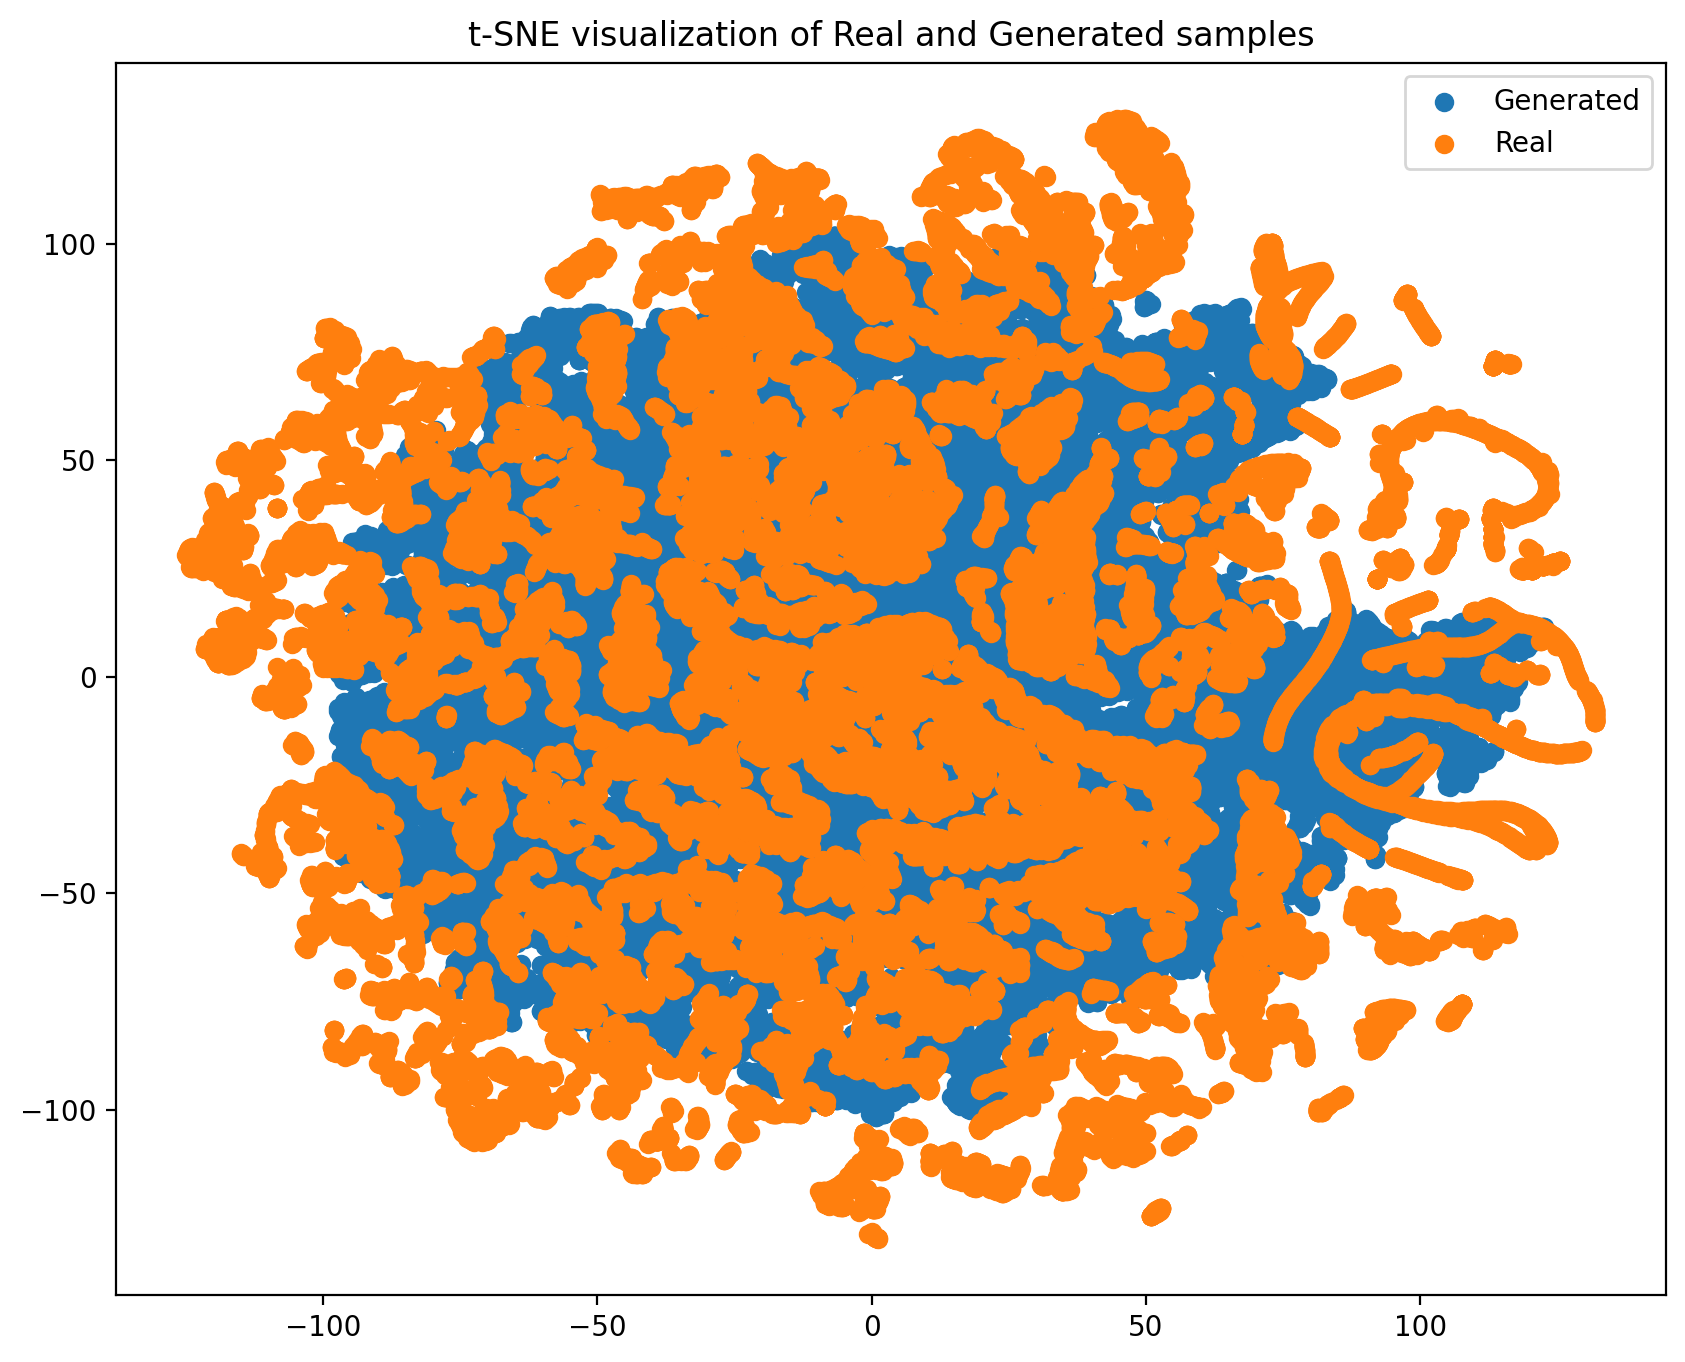

In [89]:
# Plot settings
plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')

# Prepare real data for t-SNE
real_data = dos_df.drop("label", axis=1).values

# Noise generation and prediction
noise = np.random.normal(0, 1, (len(dos_df), 32))
generated_probe = model.predict([noise, dos_df.label.values.reshape(-1, 1)])[:, :-1]

# Apply t-SNE on real and generated data
tsne_real = TSNE(n_components=2, random_state=42).fit_transform(real_data)
tsne_generated = TSNE(n_components=2, random_state=42).fit_transform(generated_probe)

# Plot generated and real data
plt.scatter(x=tsne_generated[:, 0], y=tsne_generated[:, 1], label="Generated", zorder=1)
plt.scatter(x=tsne_real[:, 0], y=tsne_real[:, 1], label="Real", zorder=2)

# Add title and legend
plt.title("t-SNE visualization of Real and Generated samples")
plt.legend()

# Show the plot
plt.show()

365/365 [==============================] - 1s 1ms/step


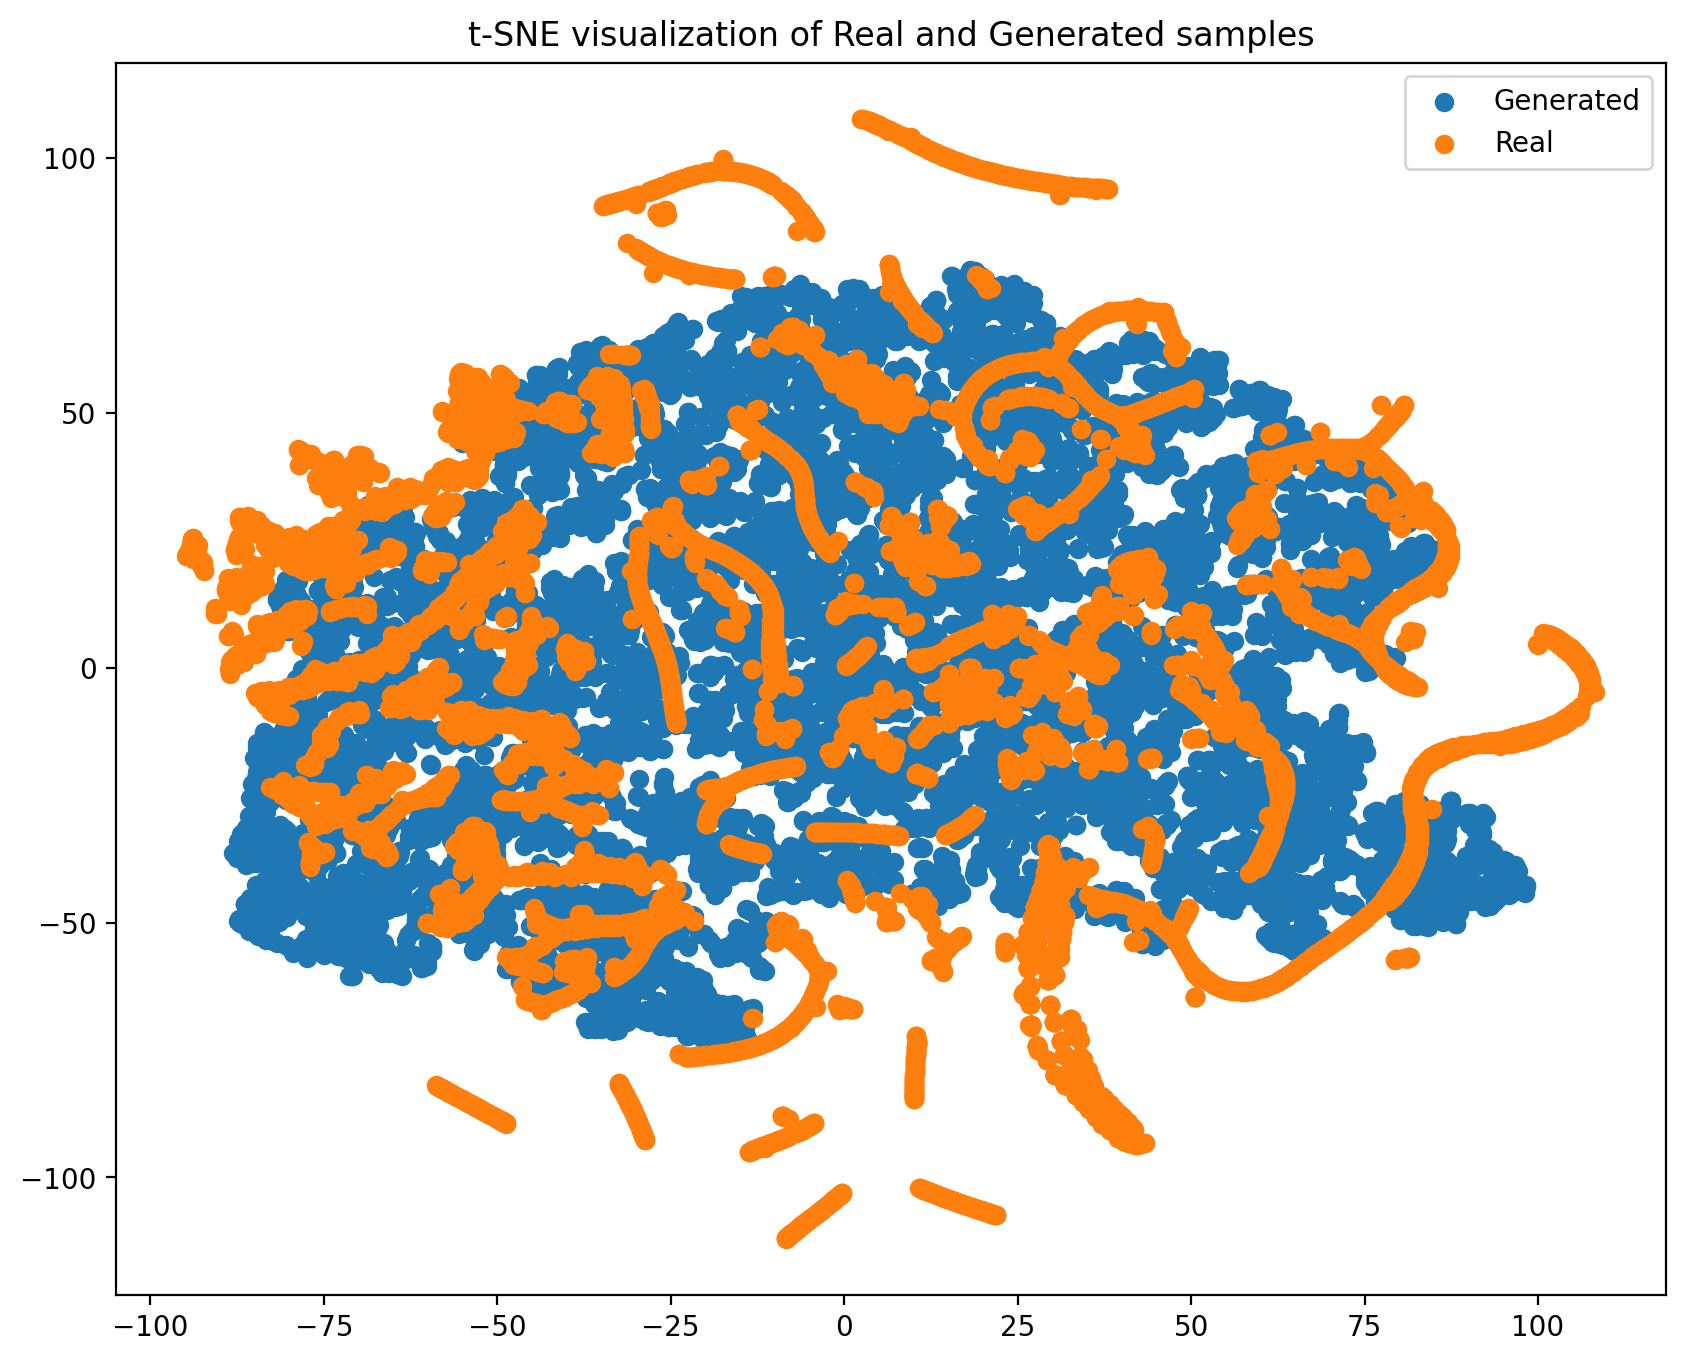

In [90]:
# Plot settings
plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')

# Prepare real data for t-SNE
real_data = probe_df.drop("label", axis=1).values

# Noise generation and prediction
noise = np.random.normal(0, 1, (len(probe_df), 32))
generated_probe = model.predict([noise, probe_df.label.values.reshape(-1, 1)])[:, :-1]

# Apply t-SNE on real and generated data
tsne_real = TSNE(n_components=2, random_state=42).fit_transform(real_data)
tsne_generated = TSNE(n_components=2, random_state=42).fit_transform(generated_probe)

# Plot generated and real data
plt.scatter(x=tsne_generated[:, 0], y=tsne_generated[:, 1], label="Generated", zorder=1)
plt.scatter(x=tsne_real[:, 0], y=tsne_real[:, 1], label="Real", zorder=2)

# Add title and legend
plt.title("t-SNE visualization of Real and Generated samples")
plt.legend()

# Show the plot
plt.show()

32/32 [==============================] - 0s 1ms/step


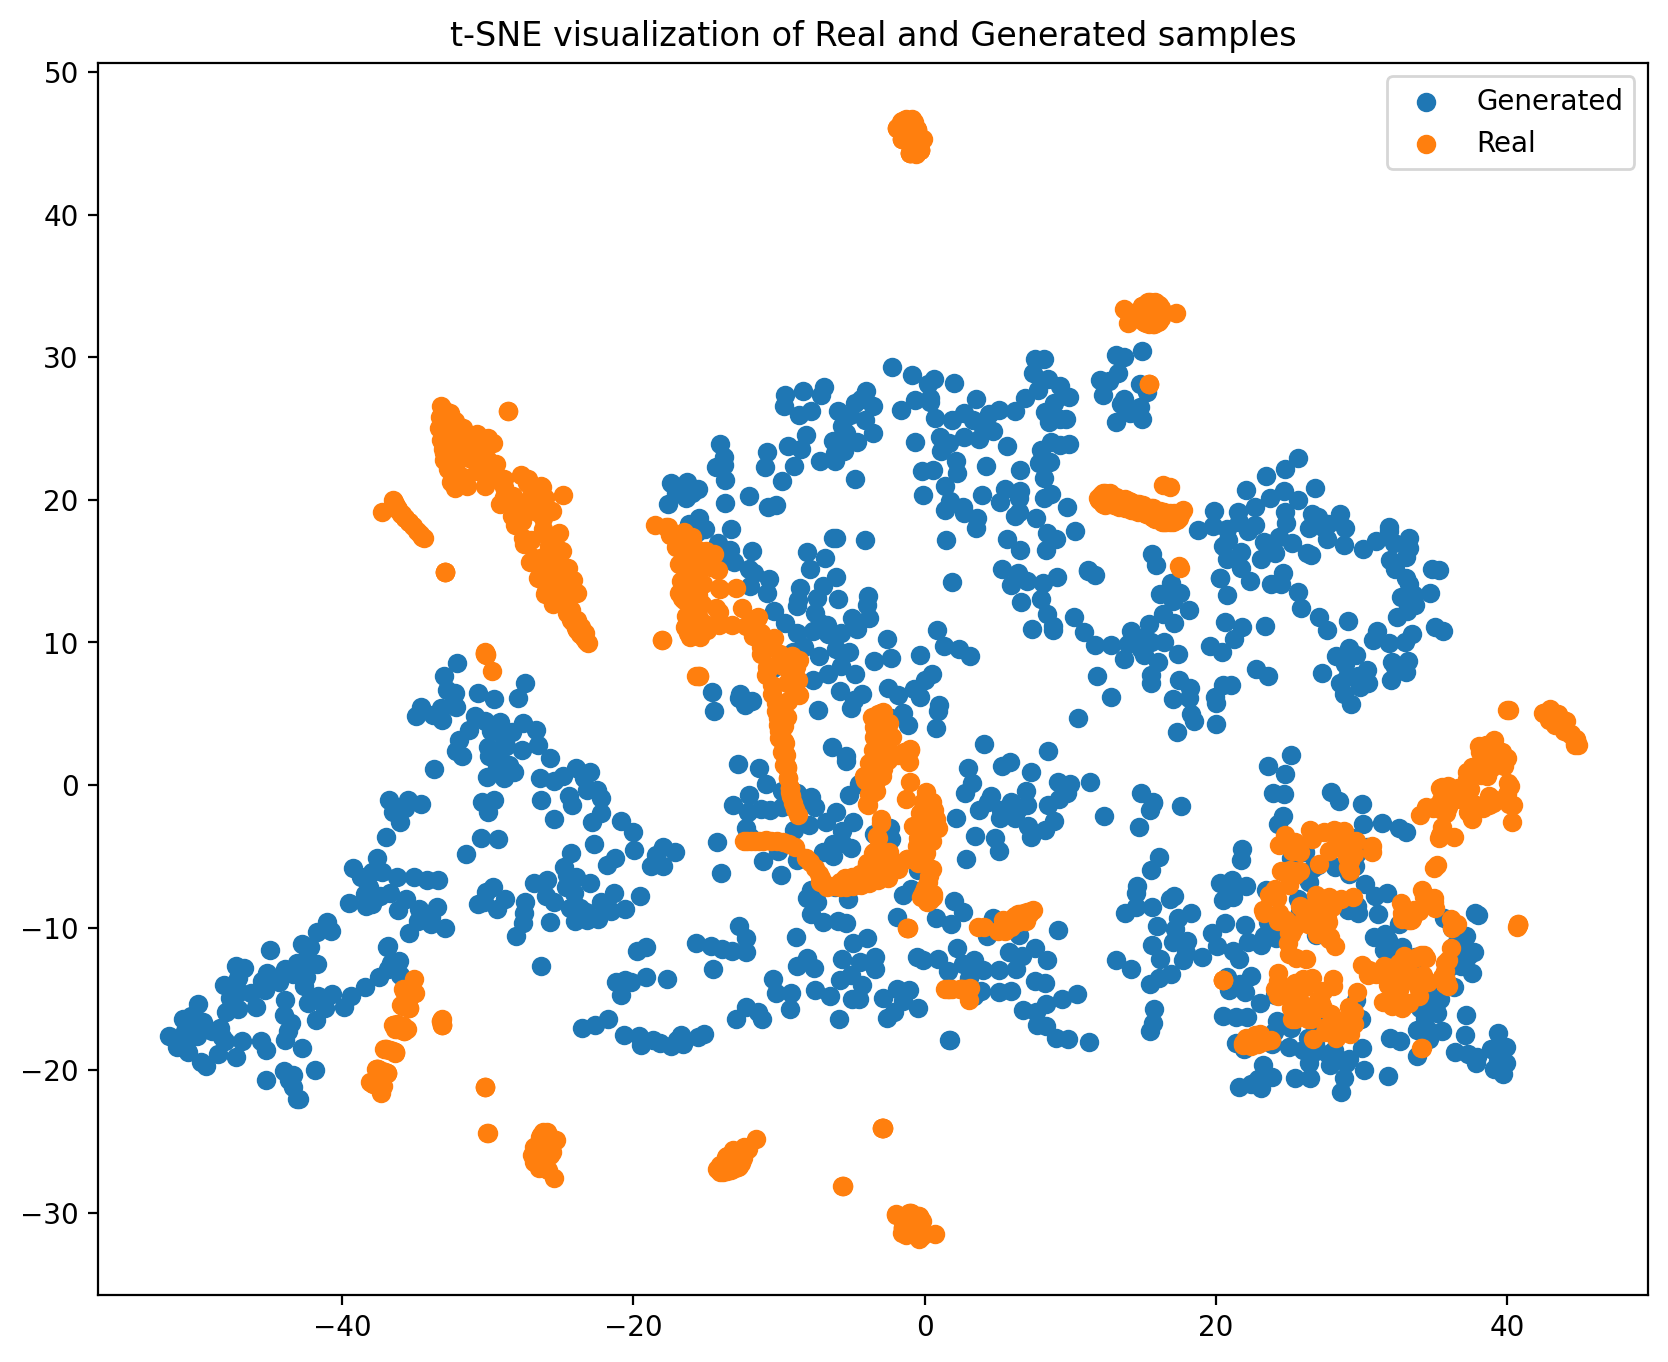

In [91]:
# Plot settings
plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')

# Prepare real data for t-SNE
real_data = r2l_df.drop("label", axis=1).values

# Noise generation and prediction
noise = np.random.normal(0, 1, (len(r2l_df), 32))
generated_probe = model.predict([noise, r2l_df.label.values.reshape(-1, 1)])[:, :-1]

# Apply t-SNE on real and generated data
tsne_real = TSNE(n_components=2, random_state=42).fit_transform(real_data)
tsne_generated = TSNE(n_components=2, random_state=42).fit_transform(generated_probe)

# Plot generated and real data
plt.scatter(x=tsne_generated[:, 0], y=tsne_generated[:, 1], label="Generated", zorder=1)
plt.scatter(x=tsne_real[:, 0], y=tsne_real[:, 1], label="Real", zorder=2)

# Add title and legend
plt.title("t-SNE visualization of Real and Generated samples")
plt.legend()

# Show the plot
plt.show()

2/2 [==============================] - 0s 2ms/step


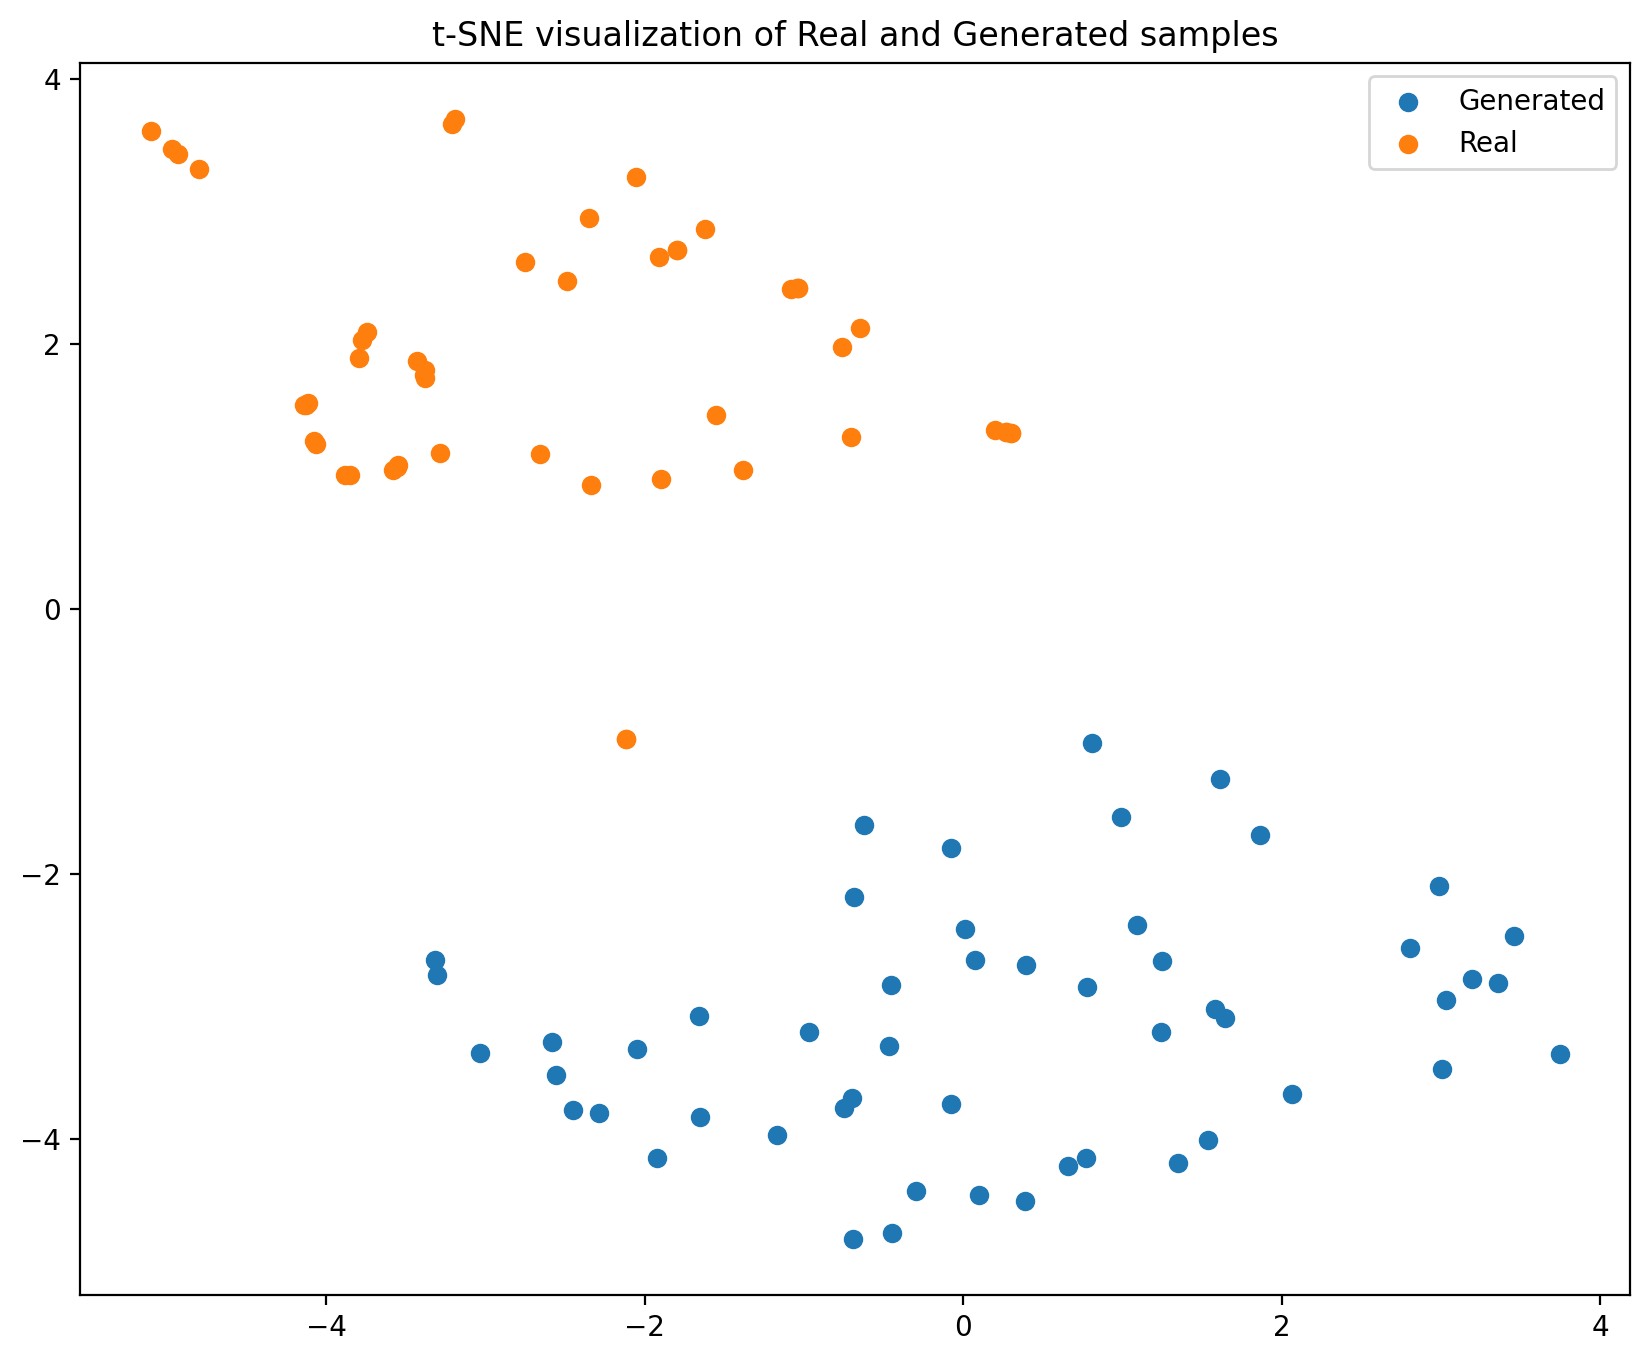

In [92]:
# Plot settings
plt.figure(num=None, figsize=(10, 8), dpi=200, facecolor='w', edgecolor='k')

# Prepare real data for t-SNE
real_data = u2r_df.drop("label", axis=1).values

# Noise generation and prediction
noise = np.random.normal(0, 1, (len(u2r_df), 32))
generated_probe = model.predict([noise, u2r_df.label.values.reshape(-1, 1)])[:, :-1]

# Apply t-SNE on real and generated data
tsne_real = TSNE(n_components=2, random_state=42).fit_transform(real_data)
tsne_generated = TSNE(n_components=2, random_state=42).fit_transform(generated_probe)

# Plot generated and real data
plt.scatter(x=tsne_generated[:, 0], y=tsne_generated[:, 1], label="Generated", zorder=1)
plt.scatter(x=tsne_real[:, 0], y=tsne_real[:, 1], label="Real", zorder=2)

# Add title and legend
plt.title("t-SNE visualization of Real and Generated samples")
plt.legend()

# Show the plot
plt.show()